In [1]:
import numpy as np
import torch
from torch import nn
import torchvision.models as models
import torchvision.transforms as T
import utils
from IPython.display import clear_output
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
torch.manual_seed(31)
mpl.style.use(["dark_background"])

### Load images;

In [2]:
style_input = utils.load_image("data/images/starry_night_darker.jpeg", 
                               apply_transform=True, shape=(480, 540))
content_input = utils.load_image("data/images/houses_denmark.jpg", 
                                 apply_transform=True, shape=(480, 540))

In [3]:
style_input = T.functional.hflip(style_input)

In [4]:
style_input.shape, content_input.shape

(torch.Size([3, 480, 540]), torch.Size([3, 480, 540]))

### Plot the images;

In [5]:
style_img = utils.tensor_to_pil(style_input, apply_transform=True)

In [6]:
fig, ax = plt.subplots(figsize=(7, 6), facecolor="black")
ax.imshow(style_img)
fig.tight_layout()
plt.show()

In [7]:
content_img = utils.tensor_to_pil(content_input, apply_transform=True)

In [8]:
fig, ax = plt.subplots(figsize=(7, 6), facecolor="black")
ax.imshow(content_img)
fig.tight_layout()
plt.show()

### Check the cache directory and load the model;

In [9]:
torch.hub.get_dir()

'/content/data/'

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
vgg19 = models.vgg19(pretrained=True).to(device)

### This model will be used to extract features, so no need for tracking gradients on the weights of its modules;

In [12]:
vgg19.requires_grad_(False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Check out the features we are dealing with;

In [13]:
def get_all_features(tensor_input, extractor, module_types=(nn.Conv2d)):
    extractor.eval()
    features = []
    for i, m in enumerate(extractor.features):
        tensor_input = extractor.features[i](tensor_input)
        if isinstance(m, module_types):
            features.append((i, tensor_input[0, :3, :, :]))  # get first 3 channels;
    return features

In [14]:
style_input = style_input.unsqueeze(0).to(device)
content_input = content_input.unsqueeze(0).to(device)

In [15]:
features_style = get_all_features(style_input, vgg19)
features_content = get_all_features(content_input, vgg19)

In [16]:
def plot_features(features, extractor, figsize=(12, 30)):
    ncols = 3
    nrows = len(features) // ncols + (1 if len(features) % ncols else 0)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, facecolor="black")
    for i, (idx, f) in enumerate(features):
        c, r = i % ncols, i // ncols
        axs[r][c].imshow(utils.tensor_to_pil(f, apply_transform=True))
        module_type = str(type(extractor.features[idx])).strip("\"\'>").split('.')[-1]
        axs[r][c].set_title(f"idx: {idx}  module type: {module_type}")
    fig.tight_layout()
    plt.show()

In [17]:
plot_features(features_style, vgg19, figsize=(12, 21))

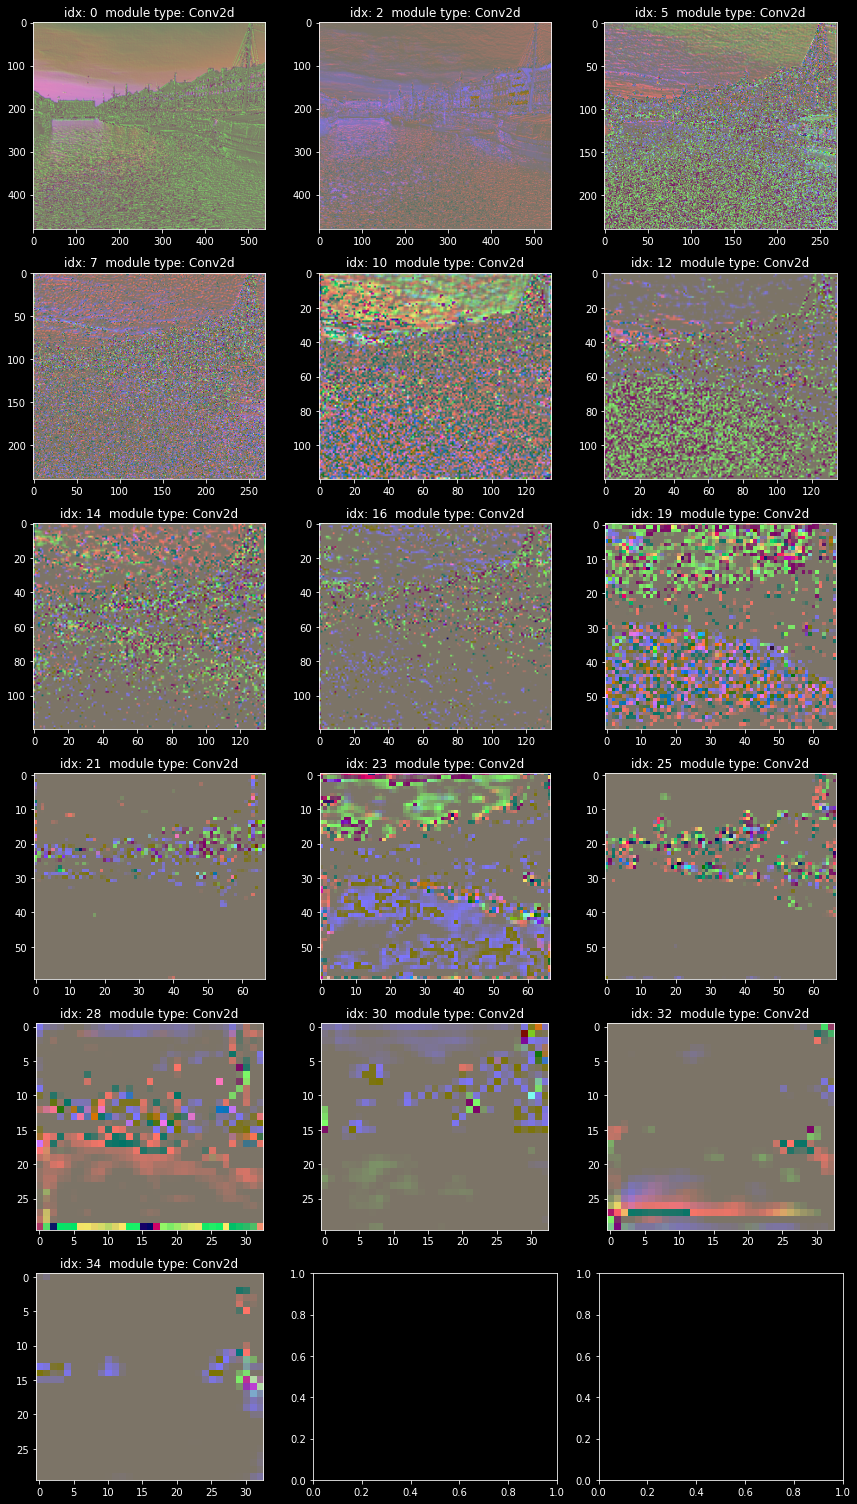

In [18]:
plot_features(features_content, vgg19, figsize=(12, 21))

### Setup similarity criterion for style features;

In [19]:
def get_gram_mat(features):
    features = features.squeeze().reshape(features.size(1), -1) / math.sqrt(features.numel())
    return features @ features.T

In [20]:
style_input.requires_grad

False

In [21]:
def get_style_loss(gram_synt, gram_base):
    assert gram_synt.shape == gram_base.shape
    return ((gram_synt - gram_base) ** 2).sum()

In [22]:
get_gram_mat(features_style[0][1]).mean()

tensor(0.0002, device='cuda:0')

### Define similarity criterion for content features;

In [23]:
def get_content_loss(content_synt, content_base, 
                     height_coef=None, width_coef=None, weight=None):
    # the height and width coefs here are fairly hacky;
    # I wanted to assign higher importance for preserving the
    # content in a particular rectangular region;
    # this worked, but esthetically was not very cool;
    # hence I'm NOT using it in the training;
    if height_coef and width_coef and weight:
        weight_mask = torch.ones(content_synt.shape, dtype=torch.float32).to(device)
        curr_h = round(height_coef * content_synt.size(-2))
        curr_w = round(width_coef * content_synt.size(-1))
        weight_mask[:, :, curr_h:, :curr_w] = weight
        return (weight_mask * ((content_synt - content_base) ** 2)).mean()
    return ((content_synt - content_base) ** 2).mean()

### Define synthetic image;

In [24]:
class SyntheticImg(nn.Module):
    def __init__(self, shape, **kwargs):
        super(SyntheticImg, self).__init__(**kwargs)
        self.param = nn.Parameter(
            torch.nn.init.xavier_normal_(
                torch.zeros(shape, dtype=torch.float32)
            )
        )
    
    def forward(self):
        return self.param

In [25]:
def get_styles_and_contents(tensor_input, extractor, style_layers, content_layers):
    # model.eval() is not necessary for vgg since only has convs and relu 
    # and maxpool but if someone wishes to use something like 
    # batch norms or others, nn.Module.eval() might be good to have;
    extractor.eval()
    styles, contents = [], []
    for idx, m in enumerate(extractor.features):
        tensor_input = extractor.features[idx](tensor_input)
        if idx in style_layers:
            styles.append(tensor_input)
        elif idx in content_layers:
            contents.append(tensor_input)
    return styles, contents

In [26]:
train_hyper_params = {
    "style_layers": {0, 5, 10, 19, 28},
    "content_layers": {7},
    "style_weight": 4e3,
    "content_weight": 1,
    "epochs": 350,
    "height_coef": None,
    "width_coef": None,
    "weight": None
}

In [27]:
base_styles, _ = get_styles_and_contents(style_input, vgg19, 
                                        train_hyper_params["style_layers"],
                                        train_hyper_params["content_layers"])
_, base_contents = get_styles_and_contents(content_input, vgg19,
                                           train_hyper_params["style_layers"],
                                           train_hyper_params["content_layers"])

In [28]:
base_styles_grams = [get_gram_mat(s) for s in base_styles]

In [29]:
def plot_synt_img(tensor_synt, figsize=(9, 6), title=None):
    clear_output()
    pil_img = utils.tensor_to_pil(tensor_synt, apply_transform=True)
    fig, ax = plt.subplots(figsize=figsize, facecolor="black")
    ax.imshow(pil_img)
    if title:
        ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [30]:
def train_loop_lbfgs(synt_img, base_styles_grams, base_contents,
               extractor, optim, 
               style_layers, content_layers,
               style_weight, content_weight, epochs,
               height_coef=None, width_coef=None, weight=None,
               figsize=(9, 6)):
    images = []
    style_losses, content_losses = [], []
    tenth = max(epochs // 10, 1)
    for t in range(epochs):
        def closure():
            
            optim.zero_grad()
            pred = synt_img()
            pred_styles, pred_contents = get_styles_and_contents(pred, extractor,
                                                    style_layers, content_layers)
            pred_style_grams = [get_gram_mat(s) for s in pred_styles]
            style_loss = style_weight * (1 / len(style_layers)) * \
                                    sum([get_style_loss(pred_s, base_s)
                                    for pred_s, base_s in zip(pred_style_grams,
                                                            base_styles_grams)])
            content_loss = content_weight * (1 / len(content_layers)) * \
                              sum([get_content_loss(pred_c, base_c, height_coef, 
                                                    width_coef, weight)
                              for pred_c, base_c in zip(pred_contents,
                                                        base_contents)])
            total_loss = style_loss + content_loss
            total_loss.backward()
            # append style and content loss;
            style_losses.append(style_loss.item())
            content_losses.append(content_loss.item())
            return total_loss
            # call the optimiser;
        optim.step(closure)
        if (t + 1) % 50 == 0:
            print(f"progress: {t+1} / {epochs}")
        if (t + 1) % tenth == 0:
            images.append(
                (t+1, torch.clamp(
                    synt_img.param.data.to("cpu").detach().clone(), -1.5, 1.5
                    ))
                )
            with torch.no_grad():
                plot_synt_img(images[-1][1], 
                              figsize=figsize, 
                              title=f"iter: {t+1}")

    return style_losses, content_losses, images

### Init and train;

In [31]:
synt_img = SyntheticImg(style_input.shape).to(device)
synt_img.param.data.copy_(content_input.data)
optim = torch.optim.LBFGS(synt_img.parameters(), lr=0.5, max_iter=30,
                          history_size=150)

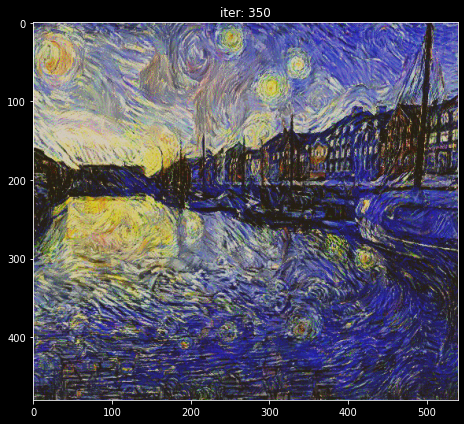

LBFGS trained for 3698.59295 seconds


In [32]:
start = time.time()
s_losses, c_losses, images = train_loop_lbfgs(synt_img, 
                                    base_styles_grams,
                                    base_contents, 
                                    vgg19, optim, 
                                    **train_hyper_params,
                                    figsize=(7, 6))
print(f"LBFGS trained for {time.time() - start:.5f} seconds")

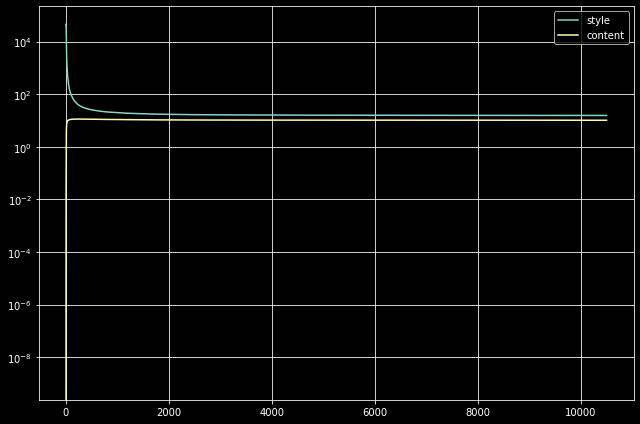

In [33]:
fig, ax = plt.subplots(figsize=(9, 6), facecolor="black")
ax.plot(s_losses, label="style")
ax.plot(c_losses, label="content")
ax.set_yscale("log")
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

In [34]:
s_losses[-10:]

[15.612628936767578,
 15.612590789794922,
 15.612554550170898,
 15.612515449523926,
 15.612481117248535,
 15.612442970275879,
 15.612408638000488,
 15.6123685836792,
 15.612332344055176,
 15.61229419708252]

In [35]:
c_losses[-10:]

[10.252974510192871,
 10.252965927124023,
 10.252958297729492,
 10.25295352935791,
 10.252946853637695,
 10.252941131591797,
 10.25293254852295,
 10.252927780151367,
 10.25291633605957,
 10.252912521362305]

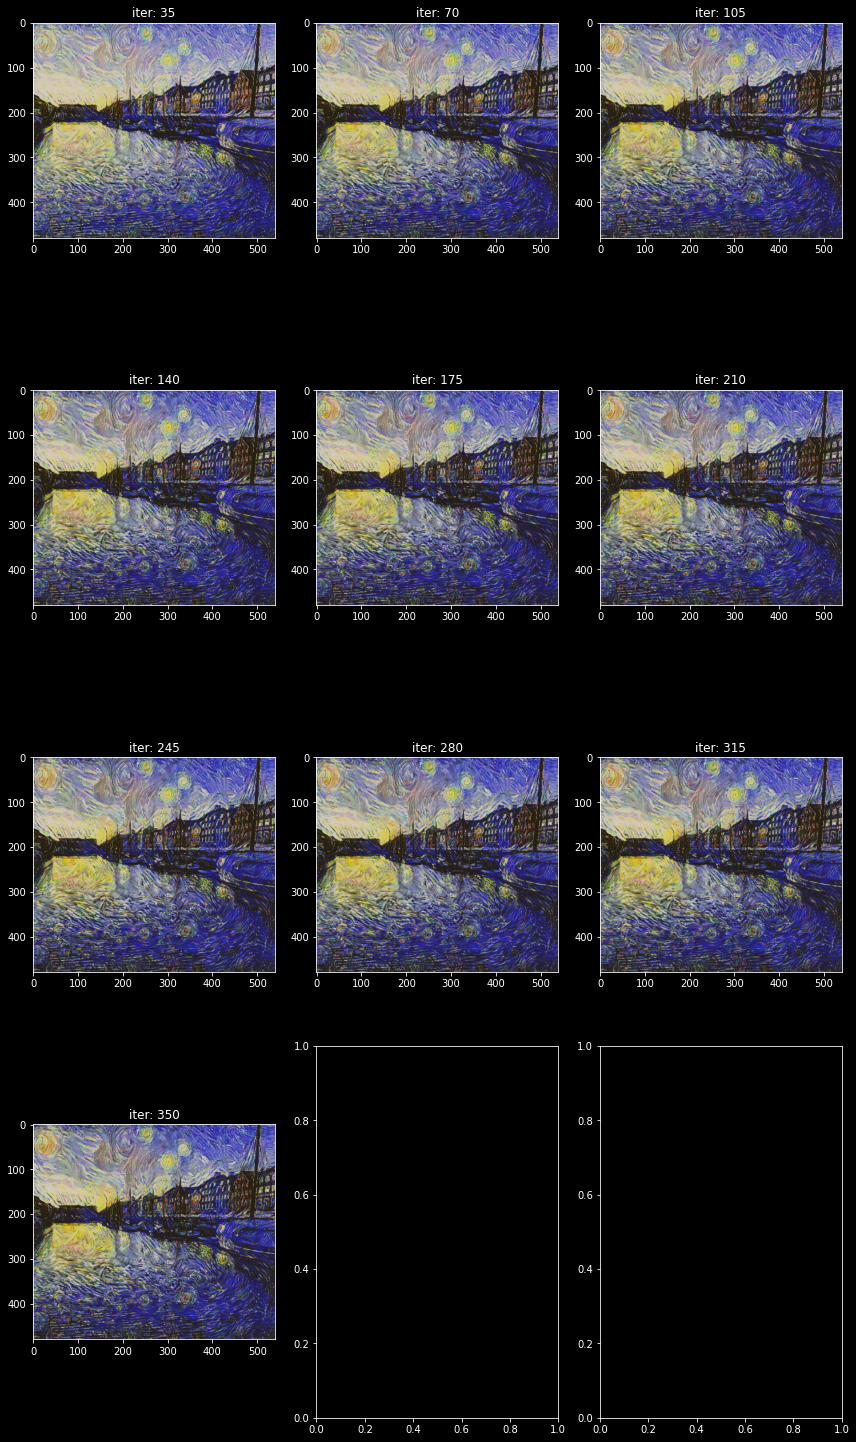

In [36]:
cols = 3
rows = len(images) // 3 + (1 if len(images) % cols else 0)
fig, axs = plt.subplots(ncols=cols, nrows=rows, 
                        figsize=(12, 21), facecolor="black")
for idx, (i, img) in enumerate(images):
    c, r = idx % cols, idx // cols
    axs[r][c].imshow(utils.tensor_to_pil(img, apply_transform=True))
    axs[r][c].set_title(f"iter: {i}")
fig.tight_layout()
plt.show()